In [25]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import optimize
import umodel as unf

import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [26]:
# Loading data cos(n, -)
with open('../data/CosThetaNminus/asimov_spinCorrelation.json', 'r') as read_file:
    dm = np.array(json.load(read_file))
    
with open('../data/CosThetaNminus/resmat_spinCorrelation.json', 'r') as read_file:
    rm = np.array(json.load(read_file))

    
# Loading data cos(n, +)
with open('../data/CosThetaNplus/asimov_spinCorrelation.json', 'r') as read_file:
    dp = np.array(json.load(read_file))
    
with open('../data/CosThetaNplus/resmat_spinCorrelation.json', 'r') as read_file:
    rp = np.array(json.load(read_file))

    
# Loading data correlations between the two observables
with open('../data/correlation_matrix_CosThetaNplus_CosThetaNminus_bins.json', 'r') as read_file:
    corrDict = json.load(read_file)

n, p = rm.shape[0], rp.shape[0]
corr = np.zeros((n+p, n+p))
for i, (iName, line) in enumerate(corrDict.items()):
    for j, (jName, c) in enumerate(line.items()):
        corr[i, j] = c

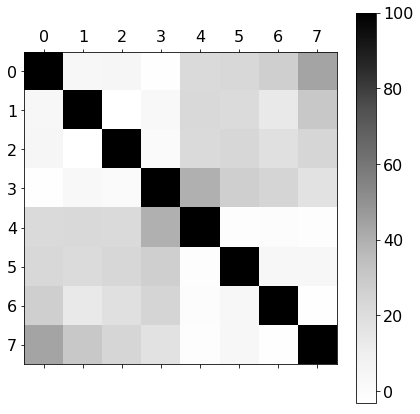

In [27]:
plt.matshow(corr*100, cmap='Greys')
plt.colorbar();

In [28]:
Ds = [dp, dm]
Rs = [rp, rm]
mCorr = unf.model(Ds, Rs, corr)
m = unf.model(Ds, Rs, corr=np.diag([1]*8))

In [22]:
# Run with correlation
BsCorr, _ = mCorr.unfold()
POIsCorr = mCorr.postFitUncerPOIs()

--> (iPOI, Min, Max, N) = (3, 755180426.5842565,834673103.06681, 10)


In [6]:
# Run without correlations
Bs, _ = m.unfold()
POIs = m.postFitUncerPOIs()

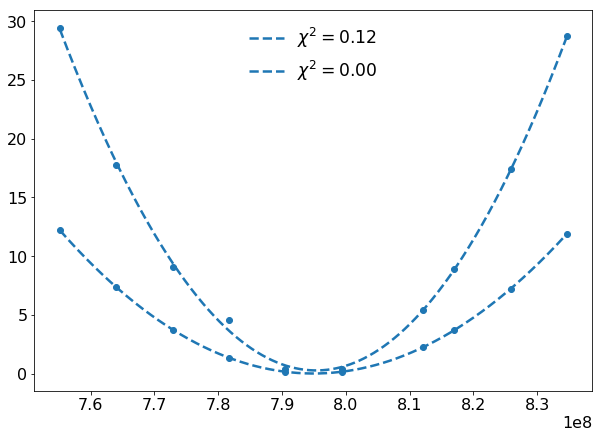

In [7]:
# Try to overlay two plots
i, xMin, xMax, n = 3, 755180426.5842565,834673103.06681, 10
mCorr.plotProfile(i, xMin, xMax, n)
m.plotProfile(i, xMin, xMax, n)

In [8]:
# Comparing result w/ and w/o corr from direct unfolding (full minimzation, only central values)
# --> no differences
bpCorr = BsCorr[0]
bmCorr = BsCorr[1]
bp = Bs[0]
bm = Bs[1]
print((bpCorr-bp)/bp)
print((bmCorr-bm)/bm)

[-1.34958344e-15  6.01910372e-16 -1.50490481e-16  1.49962606e-16]
[-1.05022485e-15 -9.02459953e-16  1.05314646e-15  0.00000000e+00]


In [9]:
# Comparing results w/ and w/o corr from profile LH
# --> differences from ~1% to 20% level!
POIsCorr = np.concatenate(POIsCorr)
POIs = np.concatenate(POIs)
relDiff = (POIsCorr-POIs) / POIs[:, 0, np.newaxis]
print( relDiff[:, 0] )

[-1.34944498e-15 -5.51714751e-05 -5.51714751e-05  4.47901992e-04
 -5.25471611e-05 -5.51714751e-05 -5.51714751e-05 -5.25471611e-05]


In [10]:
# Comparing results between unfolded and profile, w/o corr
# --> no differences
for m1, m2 in zip(POIs, np.concatenate([bp, bm])):
    print((m1[0] - m2)/m1[0])

0.00010259207638850987
0.00015775789130366348
0.000157757891303617
0.00010259207638850252
0.00010259207638860137
0.00015775789130375643
0.0001577578913036989
0.00010259207638850277


In [11]:
# Comparing results between unfolded and profiled, w/ corr
# --> large differences (from ~3% to 25%)!
for m1, m2 in zip(POIsCorr, np.concatenate([bpCorr, bmCorr])):
    print((m1[0] - m2)/m1[0])

0.00010259207638851
0.00010259207638855619
0.00010259207638856802
0.0005502476114251651
5.0047545167901095e-05
0.00010259207638852734
0.00010259207638852704
5.00475451679005e-05


# WHY ??

 + check by hand the profile for `bm[1]` bin and compare with the full minimum

In [29]:
def f(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

def compareProfile(i, xMin=0.75e9, xMax=0.85e9, n=20):
    
    yLabel = '$\\Delta$ NLL'
    xLabel = 'cos$\\theta^{+}_{n}$' + '   bin {}'.format(i)
    if i>3 :
        xLabel = 'cos$\\theta^{-}_{n}$' + '   bin {}'.format(i-4)
    
    val1, nll1 = m.profilePOI(iPOI=i, POImin=xMin, POImax=xMax, nScan=n)
    p1, _ = optimize.curve_fit(f, val1, nll1)
    plt.plot(val1, nll1, 'o', color='tab:blue')
    v1 = np.linspace(val1.min(), val1.max(), 1000)
    n1 = f(v1, *p1)
    plt.plot(v1, n1, '--', color='tab:blue', label='w/o corr')
    
    dy1 = f(val1, *p1) - nll1
    chi21 = np.mean(dy1**2)
    print(chi21)
    
    val2, nll2 = mCorr.profilePOI(iPOI=i,  POImin=xMin, POImax=xMax, nScan=n)
    p2, _ = optimize.curve_fit(f, val2, nll2)
    plt.plot(val2, nll2, 'o', color='tab:red')
    v2 = np.linspace(val2.min(), val2.max(), 1000)
    n2 = f(v2, *p2)
    plt.plot(v2, n2, '--', color='tab:red', label='w/ corr')
    
    dy2 = f(val2, *p2) - nll2
    chi22 = np.mean(dy2**2)
    print(chi22)
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend();

5.9509398740705896e-08
1.3941478210796754e-06


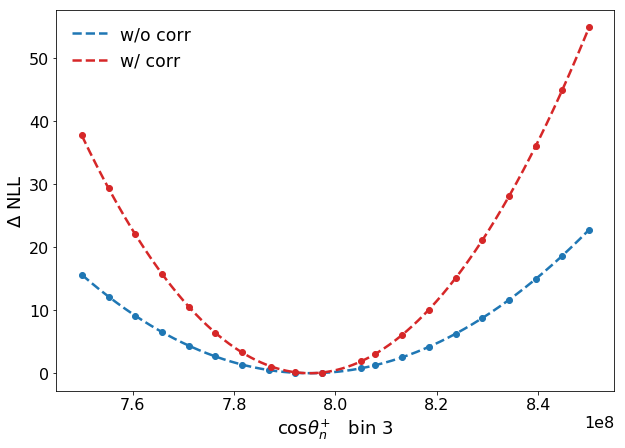

In [13]:
compareProfile(3)

1.0191476626037287e-11
2.9886603255322196e-09


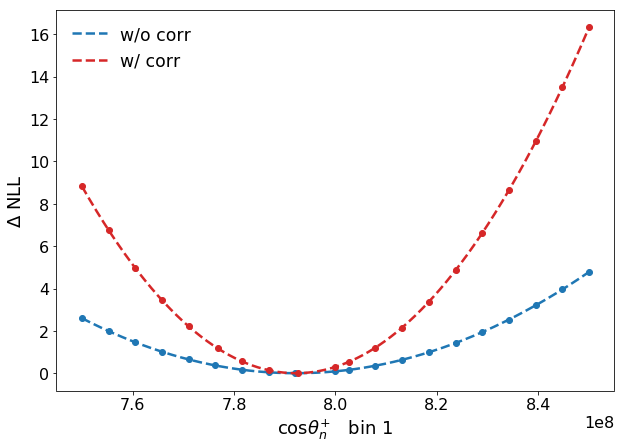

In [14]:
compareProfile(1)

3.3068853954124235e-08
4.523266679639756e-05


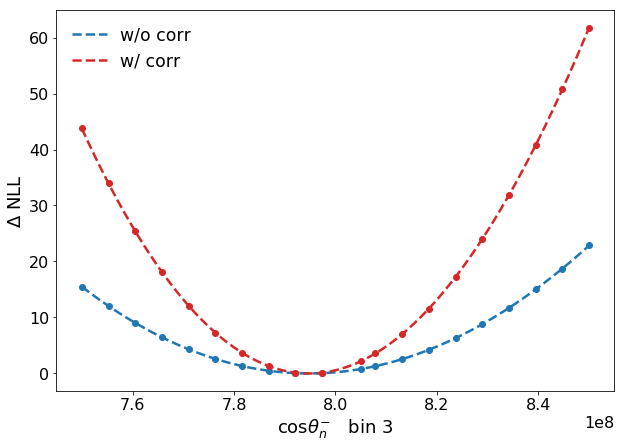

In [15]:
compareProfile(7)

3.4033668270110005e-08
109974951.03248692


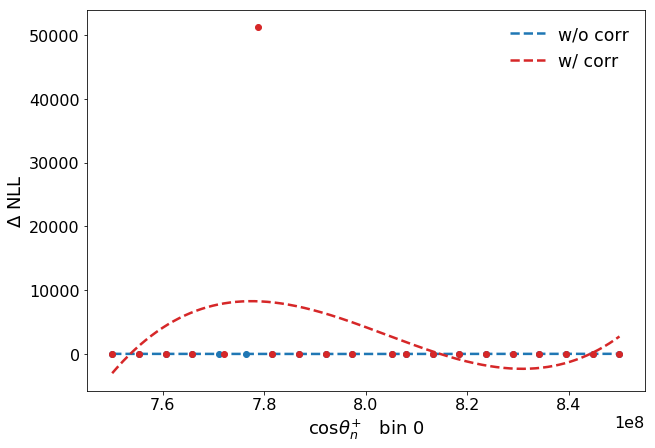

In [30]:
compareProfile(0)